In [196]:
import re, string,os
from glob import glob as gb
import pandas as pd
from collections import Counter
from tqdm import tqdm
from bs4 import BeautifulSoup as bs

with open('polish-loc.txt','r') as f:
    lcs = f.readlines()
    lcs = [x.replace('\n','').lower() for x in lcs]

In [197]:
fns = gb('/media/ruben/OSDisk/Users/ruben.ros/Documents/GitHub/ParlaMintCase/data/pl-ana-tei/*2020*sejm*') + gb('/media/ruben/OSDisk/Users/ruben.ros/Documents/GitHub/ParlaMintCase/data/pl-ana-tei/*2019*sejm*')

In [198]:
def rt(fn):
    with open(fn,'r') as f:
        c = f.read()
    return bs(c)

def EntityLemma(fn,entity='ORG'):
    soup = rt(fn)
    bd = soup.find('body')
    list_els = [x if 'type' in x.attrs.keys() else '' for x in bd.find_all('name')]
    list_els = [x for x in list_els if type(x) != str]
    list_els = [x for x in list_els if x.attrs['type'] == entity and 'w' in [t.name for t in x]]
    lemmas = []

    for el in list_els:
        lemmas.append([el.findParent().findParent().findParent().attrs['xml:id']," ".join([x.attrs['lemma'] for x in el.find_all('w')])])
    return lemmas

In [199]:
l = {}

for fn in tqdm(fns):
    l.update({"-".join(os.path.split(fn)[-1].split('-')[1:4])[3:]:EntityLemma(fn = fn, entity = "LOC")})

100%|██████████| 75/75 [08:55<00:00,  7.13s/it]


In [215]:
d = []

for k,v in l.items():

    for i in v:
        d.append([k,i[1],1])

In [216]:
d = pd.DataFrame(d,columns=["m","l","c"])
d['m'] = [x[:7] for x in d['m']]
d = d.groupby(["m","l"]).sum().reset_index()
d['l'] = [x.lower() for x in d['l']]
d = d[(d['l'].isin(lcs)) & (d['l'].isin([k for k,v in dict(Counter(d['l'])).items() if v > 10]))]

<AxesSubplot:xlabel='m'>

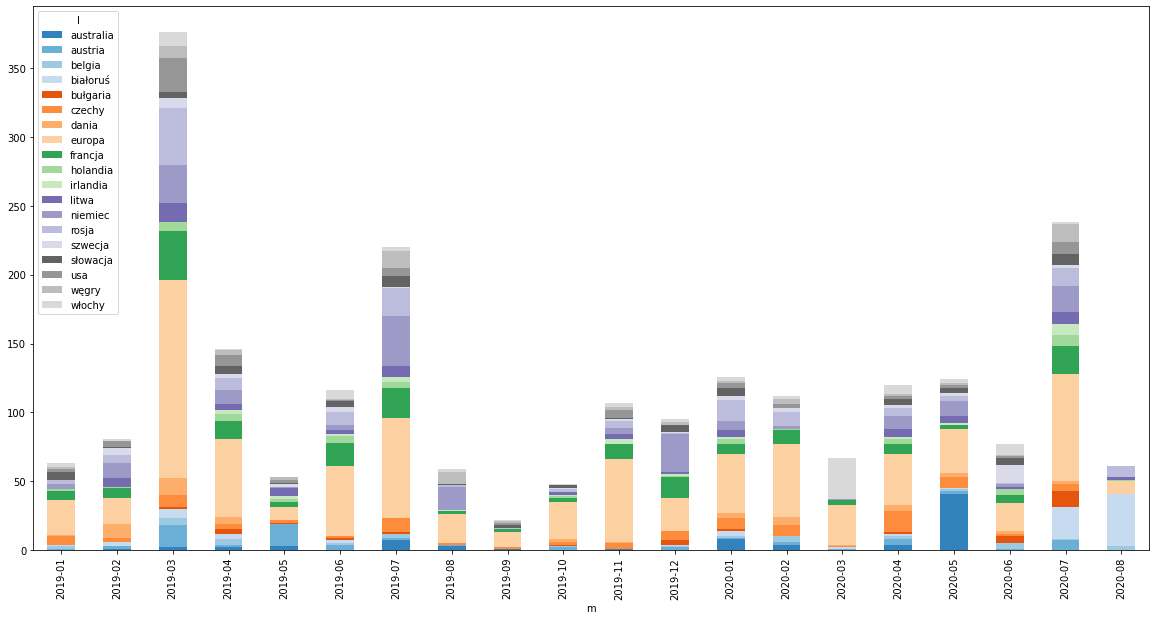

In [219]:
d = d.groupby(["m","l"]).sum().reset_index().pivot(index='m',columns='l',values='c').reset_index().fillna(0)
d.plot.bar(x='m',y=list(d.columns)[1:],figsize=(20,10),stacked=True,cmap='tab20c')